## Batted Ball In Play Predictive Model

Import Libraries

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import xgboost as xgb
import sklearn

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, mean_squared_error, average_precision_score, roc_curve, auc, recall_score, precision_score, accuracy_score, roc_auc_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
from sklearn.inspection import permutation_importance
from sklearn import datasets, metrics, model_selection, svm
from xgboost import plot_importance, XGBClassifier
from pandas import DataFrame

# Import the Data Sets

In [2]:
inplaytraining = pd.read_csv(r'C:\Users\cboat\OneDrive\Documents\In Play Prediction\training.csv')
inplaydeploy = pd.read_csv(r'C:\Users\cboat\OneDrive\Documents\In Play Prediction\deploy.csv')

# Checking Structure and Summary of the Training Data

I check the structure and summary of the data to get an understsanding of it. I then removed any missing values within the data set.

In [3]:
inplaytraining.head(10)

,InPlay,Velo,SpinRate,HorzBreak,InducedVertBreak
0,0,95.33,2893.0,10.68,21.33
1,0,94.41,2038.0,17.13,5.77
2,0,90.48,2183.0,6.61,15.39
3,0,93.04,2279.0,9.33,14.57
4,0,95.17,2384.0,6.99,17.62
5,0,95.00,2580.0,7.16,16.07
6,0,97.94,2376.0,12.29,18.11
7,0,95.42,2103.0,7.98,10.98
8,0,94.12,2535.0,5.68,18.59
9,0,93.23,2242.0,4.10,16.95


In [4]:
inplaytraining.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   InPlay            10000 non-null  int64  
 1   Velo              10000 non-null  float64
 2   SpinRate          9994 non-null   float64
 3   HorzBreak         10000 non-null  float64
 4   InducedVertBreak  10000 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 390.8 KB


In [5]:
inplaytraining.dtypes

InPlay                int64
Velo                float64
SpinRate            float64
HorzBreak           float64
InducedVertBreak    float64
dtype: object

In [6]:
inplaytraining.describe()

,InPlay,Velo,SpinRate,HorzBreak,InducedVertBreak
count,10000.000000,10000.000000,9994.000000,10000.000000,10000.000000
mean,0.271700,93.957429,2238.952471,9.549388,14.173489
std,0.444858,2.683740,196.041323,5.051887,4.607593
min,0.000000,59.760000,770.000000,-6.270000,-6.820000
25%,0.000000,92.540000,2107.000000,5.730000,11.360000
50%,0.000000,94.100000,2241.000000,9.430000,15.160000
75%,1.000000,95.660000,2367.000000,13.600000,17.630000
max,1.000000,102.040000,3061.000000,28.040000,24.860000


Reviewing and Removing Missing Values from the Data set

In [7]:
inplaytraining.isna().sum()

InPlay              0
Velo                0
SpinRate            6
HorzBreak           0
InducedVertBreak    0
dtype: int64

In [8]:
inplaytraining = inplaytraining.dropna()

In [9]:
inplaytraining.isna().sum()

InPlay              0
Velo                0
SpinRate            0
HorzBreak           0
InducedVertBreak    0
dtype: int64

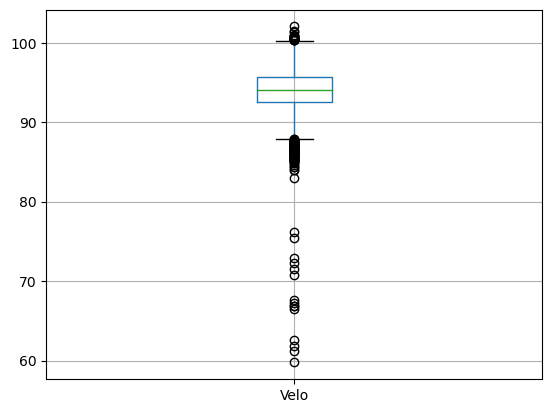

In [10]:
boxplotVelo = inplaytraining.boxplot(['Velo']) 
plt.show()

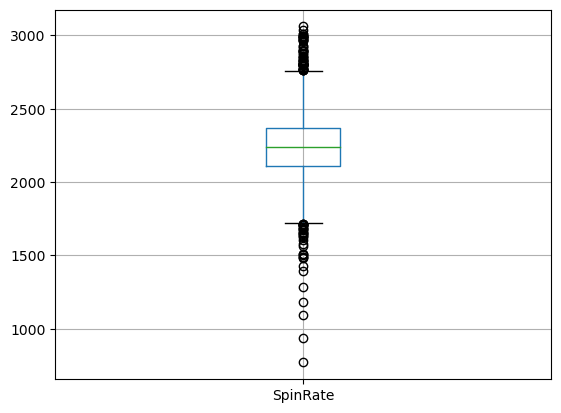

In [10]:
boxplotSpin = inplaytraining.boxplot(['SpinRate']) 
plt.show()

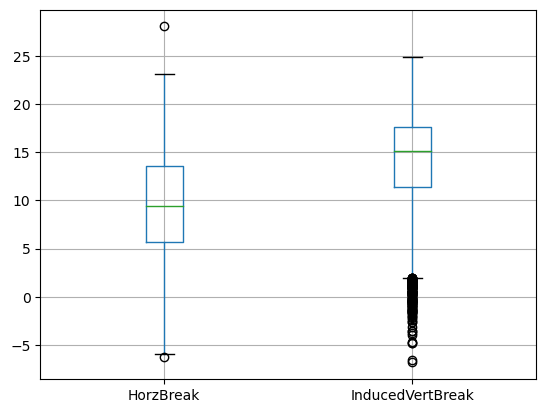

In [11]:
boxplotMovement = inplaytraining.boxplot(['HorzBreak', 'InducedVertBreak'])
plt.show()

In [12]:
VeloBelow70 = inplaytraining.loc[inplaytraining['Velo'] < 70]
VeloBelow70

,InPlay,Velo,SpinRate,HorzBreak,InducedVertBreak
142,0,67.61,1641.0,15.35,7.25
185,1,66.90,1629.0,13.55,14.67
3350,1,66.44,1391.0,-5.62,16.42
3685,0,59.76,1425.0,0.50,12.68
5153,0,62.61,1288.0,9.82,10.67
5442,1,61.17,1681.0,9.50,16.05
5836,0,61.86,1563.0,0.02,13.00
6443,1,67.28,1707.0,1.89,20.74
7903,1,66.91,1580.0,6.69,15.73


In [13]:
inplaytraining = inplaytraining[inplaytraining.Velo > 70]

In [14]:
inplaytraining

,InPlay,Velo,SpinRate,HorzBreak,InducedVertBreak
0,0,95.33,2893.0,10.68,21.33
1,0,94.41,2038.0,17.13,5.77
2,0,90.48,2183.0,6.61,15.39
3,0,93.04,2279.0,9.33,14.57
4,0,95.17,2384.0,6.99,17.62
...,...,...,...,...,...
9995,0,93.61,2074.0,13.08,7.39
9996,1,90.72,1928.0,14.10,6.08
9997,1,94.19,2694.0,0.98,14.95
9998,0,92.65,2176.0,9.28,17.62


# Difference of InPlay Outcomes

Here I checked to see the difference in the outcomes of the variable 'InPlay'. A proper predictive model needs to have an even number of outcomes between 1 and 0 in the dependent variable. If there is an outcome that occurs often, the predictive model will skew towards that outcome. There are 2.6 times the number of 0's as there are 1's. Therefore, I doubled the number of 1's within the data set by copying the rows with InPlay outcome of '1' and concatenated them to the training data set.

In [15]:
InPlay = inplaytraining.loc[inplaytraining['InPlay'] == 1]
InPlay

,InPlay,Velo,SpinRate,HorzBreak,InducedVertBreak
12,1,94.67,2357.0,12.33,12.11
13,1,91.51,2279.0,7.73,19.97
16,1,96.74,1932.0,17.59,8.85
20,1,95.89,2520.0,7.89,18.27
24,1,96.17,2034.0,18.99,4.88
...,...,...,...,...,...
9985,1,93.67,2239.0,8.84,11.07
9989,1,94.47,2328.0,7.07,19.48
9994,1,92.84,2377.0,10.48,18.77
9996,1,90.72,1928.0,14.10,6.08


In [16]:
7274 / 2711

2.683142751752121

In [17]:
frames = [inplaytraining, InPlay]
inplaytraining = pd.concat(frames)
inplaytraining

,InPlay,Velo,SpinRate,HorzBreak,InducedVertBreak
0,0,95.33,2893.0,10.68,21.33
1,0,94.41,2038.0,17.13,5.77
2,0,90.48,2183.0,6.61,15.39
3,0,93.04,2279.0,9.33,14.57
4,0,95.17,2384.0,6.99,17.62
...,...,...,...,...,...
9985,1,93.67,2239.0,8.84,11.07
9989,1,94.47,2328.0,7.07,19.48
9994,1,92.84,2377.0,10.48,18.77
9996,1,90.72,1928.0,14.10,6.08


In [18]:
InPlay = inplaytraining.loc[inplaytraining['InPlay'] == 1]
InPlay

,InPlay,Velo,SpinRate,HorzBreak,InducedVertBreak
12,1,94.67,2357.0,12.33,12.11
13,1,91.51,2279.0,7.73,19.97
16,1,96.74,1932.0,17.59,8.85
20,1,95.89,2520.0,7.89,18.27
24,1,96.17,2034.0,18.99,4.88
...,...,...,...,...,...
9985,1,93.67,2239.0,8.84,11.07
9989,1,94.47,2328.0,7.07,19.48
9994,1,92.84,2377.0,10.48,18.77
9996,1,90.72,1928.0,14.10,6.08


In [19]:
7274 - 5422

1852

In [20]:
InPlay2 = InPlay.head(1852)
InPlay2

,InPlay,Velo,SpinRate,HorzBreak,InducedVertBreak
12,1,94.67,2357.0,12.33,12.11
13,1,91.51,2279.0,7.73,19.97
16,1,96.74,1932.0,17.59,8.85
20,1,95.89,2520.0,7.89,18.27
24,1,96.17,2034.0,18.99,4.88
...,...,...,...,...,...
6744,1,94.49,2169.0,5.71,15.20
6747,1,96.95,2266.0,14.35,9.32
6762,1,95.52,2188.0,16.01,11.86
6764,1,91.51,2158.0,6.15,17.71


In [21]:
frames = [inplaytraining, InPlay2]
inplaytraining = pd.concat(frames)
inplaytraining

,InPlay,Velo,SpinRate,HorzBreak,InducedVertBreak
0,0,95.33,2893.0,10.68,21.33
1,0,94.41,2038.0,17.13,5.77
2,0,90.48,2183.0,6.61,15.39
3,0,93.04,2279.0,9.33,14.57
4,0,95.17,2384.0,6.99,17.62
...,...,...,...,...,...
6744,1,94.49,2169.0,5.71,15.20
6747,1,96.95,2266.0,14.35,9.32
6762,1,95.52,2188.0,16.01,11.86
6764,1,91.51,2158.0,6.15,17.71


# Correlation Plot

I created the correlation plot below to determine if there are any highly correlated attributes. Highly correlated attributes can create noise within a predictive model and therefore should be removed. As shown below, there was no need to remove any attributes within this data set. The most correlated attributes is between 'InducedVertBreak' and 'HorzBreak' as a -0.575536. This shows that as the pitch 'rises' or drops less than expected, the less the amount of horizontal movement we can expect. This would make sense as most pitches that 'rise' are high spin four seam fastballs and typically do not have much break left or right.

Looking at the correlation between 'InPlay' and the other features, you will notice that there are no highly correlated attributes to it. In fact, the correlations seem to be fairly close to zero amongst all four. This means that the model could use all four attributes fairly evenly when learning.

In [22]:
corr = inplaytraining.corr()
corr.style.background_gradient(cmap='coolwarm')

,InPlay,Velo,SpinRate,HorzBreak,InducedVertBreak
InPlay,1.000000,-0.057810,-0.076007,0.084954,-0.110563
Velo,-0.057810,1.000000,0.343859,-0.003062,0.113430
SpinRate,-0.076007,0.343859,1.000000,-0.253328,0.403087
HorzBreak,0.084954,-0.003062,-0.253328,1.000000,-0.575493
InducedVertBreak,-0.110563,0.113430,0.403087,-0.575493,1.000000


# Train Test Split

I split the training data into a train and test set in preparation for the predictive model. 

In [23]:
Target = inplaytraining.InPlay

In [24]:
Target.unique()

array([0, 1], dtype=int64)

In [25]:
Features = inplaytraining.drop('InPlay', axis=1)

In [26]:
Features.head(10)

,Velo,SpinRate,HorzBreak,InducedVertBreak
0,95.33,2893.0,10.68,21.33
1,94.41,2038.0,17.13,5.77
2,90.48,2183.0,6.61,15.39
3,93.04,2279.0,9.33,14.57
4,95.17,2384.0,6.99,17.62
5,95.00,2580.0,7.16,16.07
6,97.94,2376.0,12.29,18.11
7,95.42,2103.0,7.98,10.98
8,94.12,2535.0,5.68,18.59
9,93.23,2242.0,4.10,16.95


In [27]:
x_train, x_test, y_train, y_test = train_test_split(Features, Target, train_size = 0.9, test_size = 0.1, random_state = 3957)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(13093, 4) (1455, 4) (13093,) (1455,)


# Cross Validation Score

The below block of code uses a cross validation score to determine what would be the best model to use to predict the chances of a ball being put in play. I appended five models including XGBoost, Logistic Regression, Random Forest Classifier and Regression and Decision Tree. The code then determines which model had the highest score showing which is best to use. In this case the Random Forest Classification had the highest score thus making it the best model choice. 

The reason the Random Forest Classification becomes the best model is due to a number of factors. When the machine is learning on how to predict based upon a binary dependent variable, it becomes difficult to use a regression model. Regression model typically predicts scores based on a non-binary dependent variable. Since the dependent variable is binary in this case, Random Forest Regression performed poorly. 

The number of independent variables is quite low being only four, which would mean that Logistic Regression wouldn't be the best choice as it typically performs better with more attributes. With more independent variables, Logistic Regression would be able to obtain more combinations to determine what mix of attributes did best. With only four independent variables, it becomes tough to obtain a proper combination.

The XGBoost model performed the next worst because it didn't have the volume of data needed to learn sufficiently from this dataset. XGBoost builds its trees in a parallel manner which requires large amounts of data, whereas Random Forest built its trees individually and takes the average of all trees built. For this output, the parallel way was not ideal. 

Lastly, just behind Random Forest Classification was the Desicion Tree. Although Random Forest Classification, XGBoost and Decision Tree are all tree based models, Decision Tree only builds a singular tree, thus causing an increase chance of inaccuracy whereas Random Forest uses multiple trees and takes the average score thus lowering the chance of inaccuracy.

Random Forest Classification worked the best because of the binary output of the dependent variable, the limited data within the data set and the style in which it builds its trees produced the high score.

In [28]:
models = []

models.append(("XGB", xgb.XGBClassifier(max_depth = 2, n_estimators = 4, n_jobs = -1)))
models.append(("LogisticRegression", LogisticRegression(max_iter=100)))
models.append(("RandomForestClassification", RandomForestClassifier()))
models.append(("RandomForestRegression", RandomForestRegressor()))
models.append(("DecisionTree", DecisionTreeClassifier()))

results = []
names = []

for name,model in models:
    print("===================================================")
    print(name)
    result = cross_val_score(model, x_train, y_train)
    names.append(name)
    results.append(result)
    
print("===========================================")

for i in range(len(names)):
    print(names[i],results[i].mean())
    


XGB
LogisticRegression
RandomForestClassification
RandomForestRegression
DecisionTree
XGB 0.5439562391654569
LogisticRegression 0.5469344751333836
RandomForestClassification 0.841136742107027
RandomForestRegression 0.4999883485461096
DecisionTree 0.790803819184656


# Tuned Random Forest Classification Model

I tuned the Random Forest Classification model to maximize accruacy when predicting batted balls in play. I then predicted the probability of a '0' and '1' InPlay outcomes using the features test set and random forest model.

In [33]:
rf_n_estimators = [int(x) for x in np.linspace(200, 1000, 5)]
rf_n_estimators.append(1500)
rf_n_estimators.append(2000)

# Maximum number of levels in tree
rf_max_depth = [int(x) for x in np.linspace(5, 55, 11)]
# Add the default as a possible value
rf_max_depth.append(None)

# Number of features to consider at every split
rf_max_features = ['auto', 'sqrt', 'log2']

# Minimum number of samples required to split a node
rf_min_samples_split = [int(x) for x in np.linspace(2, 10, 9)]

# Minimum decrease in impurity required for split to happen
rf_min_impurity_decrease = [0.0, 0.05, 0.1]

# Method of selecting samples for training each tree
rf_bootstrap = [True, False]

# Create the grid
rf_grid = {'n_estimators': rf_n_estimators,
               'max_depth': rf_max_depth,
               'max_features': rf_max_features,
               'min_samples_split': rf_min_samples_split,
               'min_impurity_decrease': rf_min_impurity_decrease,
               'bootstrap': rf_bootstrap}

In [34]:
rf_base = RandomForestClassifier()

# Create the random search Random Forest
rf_random = RandomizedSearchCV(estimator = rf_base, param_distributions = rf_grid, 
                               n_iter = 200, cv = 3, verbose = 2, random_state = 42, 
                               n_jobs = -1)

# Fit the random search model
rf_random.fit(x_train, y_train)

# View the best parameters from the random search
rf_random.best_params_

Fitting 3 folds for each of 200 candidates, totalling 600 fits


{'n_estimators': 800,
 'min_samples_split': 2,
 'min_impurity_decrease': 0.0,
 'max_features': 'auto',
 'max_depth': 40,
 'bootstrap': False}

In [35]:
model = RandomForestClassifier(n_estimators = 800,
                                 min_samples_split = 2,
                                 min_impurity_decrease = 0.0,
                                 max_features = 'auto',
                                 max_depth = 40,
                                 bootstrap = False)

In [36]:
model.fit(x_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=40, n_estimators=800)

# Prediction and Sanity Checks

I used the model created above and predicted the probability of a 0 and 1 outcome. The predictions were then placed into a data frame with the columns of Prob_0 and Prob_1 showing the probability of each outcome respectively. I then compared the sum of InPlay actuals ('y_test') and Prob_1 as a sanity check. If the sums are close in output, then I can be confident in the accuracy of the model but if the sums are way off, then the model needs to be reassessed and improved. In this case the sums are close in output, so the model has passed this sanity check. The next sanity check I ran was the accuracy score. The score was 0.885 or the model predicted on an 88.5% accuracy rate thus showing the model passing on the second sanity check. The last check is the Area Under the Curve (AUC) score which is 0.952 or 95.2% showing that the model performed well predicting outputs of 0's and 1's compared to the actuals. 

The Random Forest model created passed all three sanity checks, thus allowing me to be confident in the model output.

In [37]:
pred = model.predict(x_test)
prob = model.predict_proba(x_test)
pred
prob

array([[0.7225    , 0.2775    ],
       [0.        , 1.        ],
       [0.96875   , 0.03125   ],
       ...,
       [0.77375   , 0.22625   ],
       [0.66954171, 0.33045829],
       [0.01158152, 0.98841848]])

In [38]:
prob_model = pd.DataFrame(prob, columns = ['Prob_0', 'Prob_1'])

In [39]:
y_test.sum()

731

In [40]:
prob_model['Prob_1'].sum()

911.148589339107

In [41]:
acc_score = accuracy_score(y_test, pred)
acc_score

0.934020618556701

In [42]:
roc_auc_score = roc_auc_score(y_test, prob_model['Prob_1'])
roc_auc_score

0.9854282712699624

# ROC Curve

The below chart shows the AUC score. The chart shows how well the model did at predicting the outcomes of 0's and 1's within it generating a curve going from (0,0), moving to the top left and gradually curving to (1,1).

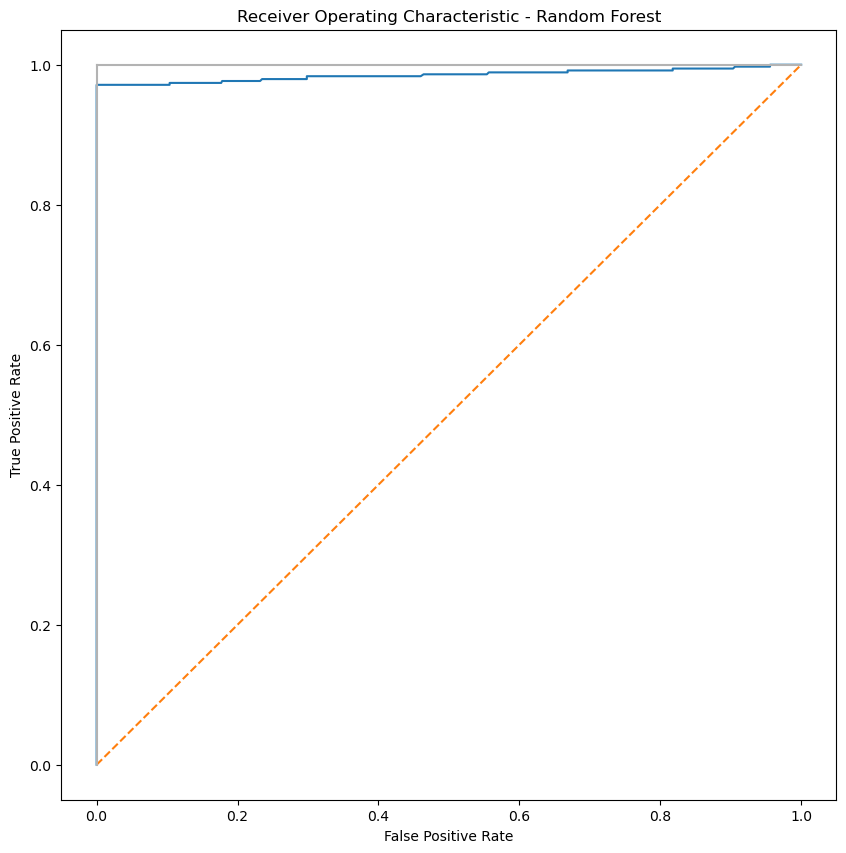

In [43]:
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, prob_model['Prob_1'])

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Random Forest')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [44]:
importances = model.feature_importances_
sorted_indices = np.argsort(importances)[::-1]

In [45]:
sorted_indices

array([2, 3, 0, 1], dtype=int64)

In [46]:
importances

array([0.25230729, 0.24023891, 0.2544131 , 0.2530407 ])

# Feature Importance Chart

The below chart shows the importance of each feature within the model and how it valued each variable when learning to create predictions. Interestingly enough, it shows that all variables have a near identical importance to the model learning what constitutes an output of a 0 and 1. This would mean that this model shows that there isn't one feature that a pitcher should focus on to prevent batted balls in play. 

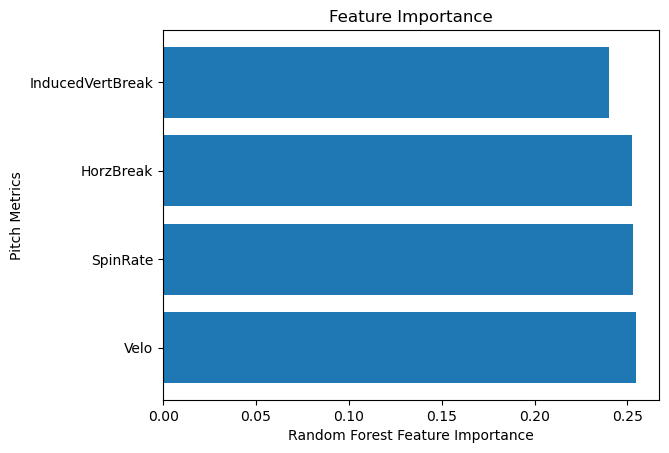

In [47]:
plt.barh(x_train.columns, importances[sorted_indices])
plt.xlabel("Random Forest Feature Importance")
plt.title('Feature Importance')
plt.ylabel('Pitch Metrics')
plt.show()

# Check Summary, Structure and NA Values in Deployment Data

I checked the structure, summary and removed the NA values from the deployment data much like I did for the training data.

In [48]:
inplaydeploy.head(10)

,Velo,SpinRate,HorzBreak,InducedVertBreak
0,94.72,2375.0,3.10,18.15
1,95.25,2033.0,11.26,14.50
2,92.61,2389.0,11.00,21.93
3,94.94,2360.0,6.84,18.11
4,97.42,2214.0,16.70,13.38
5,95.98,2495.0,11.25,17.12
6,94.88,1998.0,15.13,15.22
7,92.73,2049.0,1.55,18.47
8,92.39,1955.0,18.15,7.25
9,95.77,1976.0,10.04,14.56


In [49]:
inplaydeploy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Velo              10000 non-null  float64
 1   SpinRate          9987 non-null   float64
 2   HorzBreak         10000 non-null  float64
 3   InducedVertBreak  10000 non-null  float64
dtypes: float64(4)
memory usage: 312.6 KB


In [50]:
inplaydeploy.isna().sum()

Velo                 0
SpinRate            13
HorzBreak            0
InducedVertBreak     0
dtype: int64

In [51]:
inplaydeploy = inplaydeploy.dropna()

In [52]:
inplaydeploy.isna().sum()

Velo                0
SpinRate            0
HorzBreak           0
InducedVertBreak    0
dtype: int64

In [53]:
len(inplaydeploy)

9987

# Predict Values Using Model on Deployment Data

I used the created model to predict batted ball in play outcomes onto the deployment data set and put them into a data fram 'prob_deploy'. I then checked the length of 'prob_deploy' to see if it matches the length of the deployment data set as a sanity check. The length matches thus the sanity check passes and can be merged together using the 'Prob_1' column showing the probability of a 1 occuring. 

In [54]:
prob_deploy = model.predict_proba(inplaydeploy)
prob_deploy

array([[0.86011136, 0.13988864],
       [0.81555556, 0.18444444],
       [0.85625   , 0.14375   ],
       ...,
       [0.65515589, 0.34484411],
       [0.83322266, 0.16677734],
       [0.82729636, 0.17270364]])

In [55]:
prob_deploy = pd.DataFrame(prob_deploy, columns = ['Prob_0', 'Prob_1'])

In [56]:
len(prob_deploy)

9987

In [59]:
prob_deploy['Prob_1'].sum()

2918.475884836322

In [57]:
final_df = pd.merge(inplaydeploy, prob_deploy['Prob_1'], left_index=True, right_index=True, how='left')
final_df.head(30)

,Velo,SpinRate,HorzBreak,InducedVertBreak,Prob_1
0,94.72,2375.0,3.10,18.15,0.139889
1,95.25,2033.0,11.26,14.50,0.184444
2,92.61,2389.0,11.00,21.93,0.143750
3,94.94,2360.0,6.84,18.11,0.328346
4,97.42,2214.0,16.70,13.38,0.185000
5,95.98,2495.0,11.25,17.12,0.287500
6,94.88,1998.0,15.13,15.22,0.250000
7,92.73,2049.0,1.55,18.47,0.404009
8,92.39,1955.0,18.15,7.25,0.127500
9,95.77,1976.0,10.04,14.56,0.101250


In [58]:
final_df.to_csv(r'C:\Users\cboat\OneDrive\Documents\In Play Prediction\InPlayPredictionScores.csv')

# Next Steps

The next steps I would take would be to find other variable such as; the location of the pitch, effective velocity, spin axis etc. and look to add them into the model. The more potential variables being introduced to the model would allow it to relearn what is best to predict the probability of balls in play as well as potentially change the feature importance scores. A change in the importance scores would give me a better idea of what pitchers should focus on to limit balls in play. There would be some intricate data cleaning needed as a pitch thrown two feet off the plate would result in a higher chance of it not being put in play, but that pitch results in a negative outcome of a ball. That being said, more variables would allow for a more intricate model and potentially a clearer understanding of what negates a batter's ability of putting a ball in play.